# Практическое ДЗ 1. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [ ]:
%pip install -q moviepy==1.0.3
%pip install -q ffmpeg

  Preparing metadata (setup.py) ... done


In [ ]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
video.fps

23.976023976023978

In [ ]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_h, size_w = video.size
    arr = np.zeros([nframes, size_w, size_h])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 60 x 80, 
number of frames: 2883


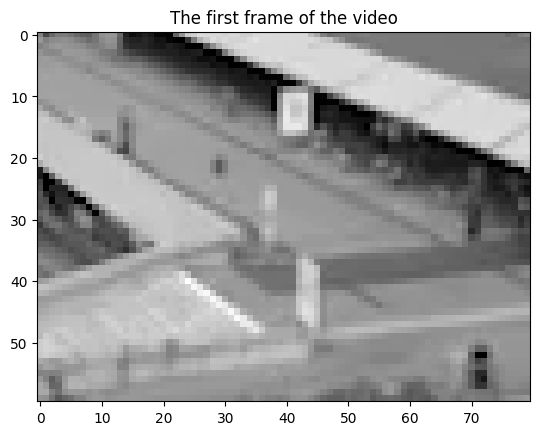

In [ ]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

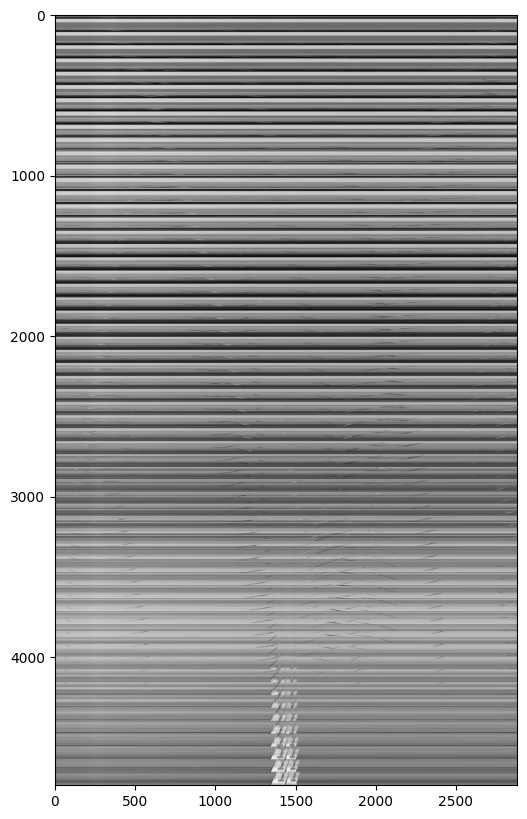

In [ ]:
nframes, size_w, size_h = arr.shape
M = np.reshape(arr, (nframes, size_w * size_h), order = "C").T

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

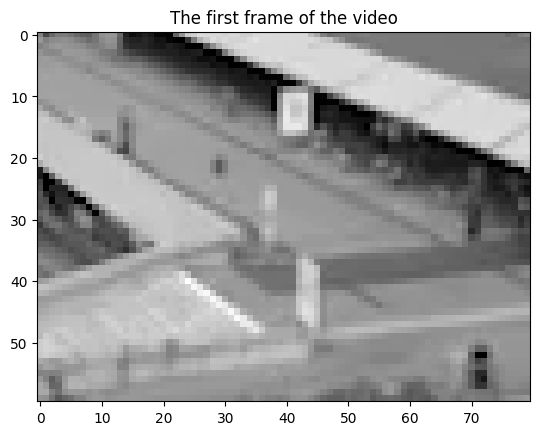

In [ ]:
first_frame = M[:,0].reshape(size_w, size_h)
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных.

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

In [ ]:
U, S, Vh = np.linalg.svd(M, full_matrices=False)

In [ ]:
S_norm = S / S[0]

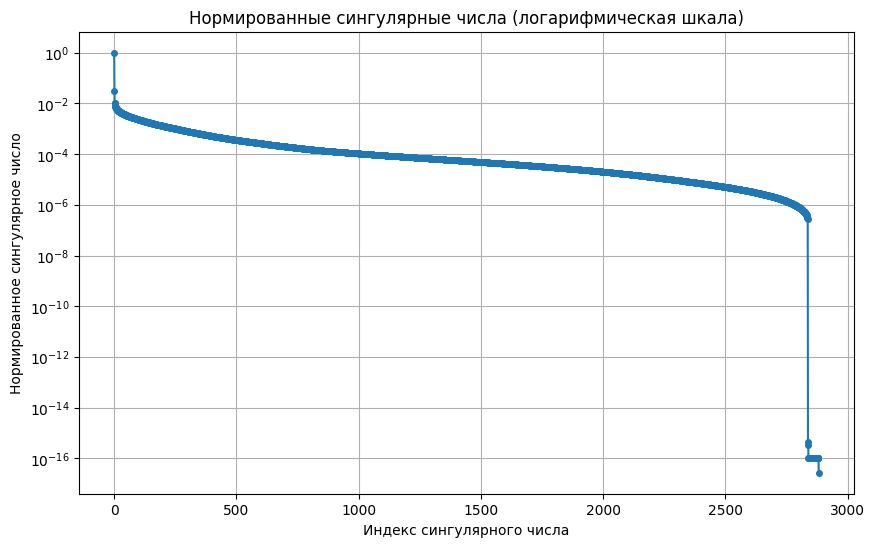

In [ ]:
plt.figure(figsize=(10, 6))
plt.semilogy(S_norm, 'o-', markersize=4)
plt.title('Нормированные сингулярные числа (логарифмическая шкала)')
plt.xlabel('Индекс сингулярного числа')
plt.ylabel('Нормированное сингулярное число')
plt.grid(True)
plt.show()

График показывает явное убывание сингулярных чисел: наибольшее сингулярное число будет значительно больше остальных, а несколько наименьших — близки к нулю. Так происходит, потому что данные имеют низкоранговую структуру, где фон (главный компонент) доминирует, а движущиеся объекты и шум вносят меньший вклад.


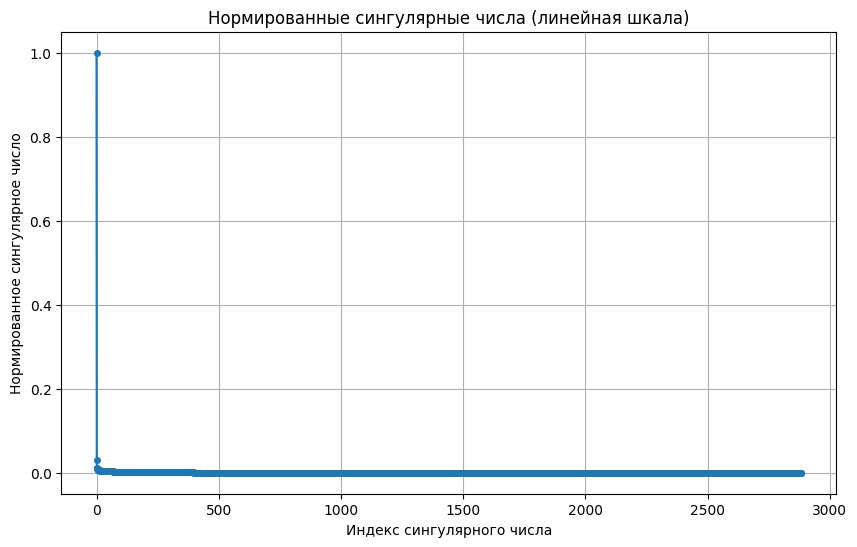

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(S_norm, 'o-', markersize=4)
plt.title('Нормированные сингулярные числа (линейная шкала)')
plt.xlabel('Индекс сингулярного числа')
plt.ylabel('Нормированное сингулярное число')
plt.grid(True)
plt.show()


Если построить график без логарифмической шкалы, разница между сингулярными числами будет такой, что график станет неинформативным. Логарифмическая шкала действительно позволяет наглядно увидеть характер убывания сингулярных чисел.

3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в фробениусовой норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$.

In [ ]:
def trunc_svd(M, r):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation

        Output
            Mr: 2D numpy array of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    U, S, Vh = np.linalg.svd(M, full_matrices=False)

    U_r = U[:, :r]
    S_r = S[:r]
    Vh_r = Vh[:r, :]


    Mr = U_r @ np.diag(S_r) @ Vh_r

    frob_norm_M = np.linalg.norm(S, ord=2)
    frob_norm_M_minus_Mr = np.linalg.norm(S[r:], ord=2)
    rel_eps = frob_norm_M_minus_Mr / frob_norm_M

    return Mr, rel_eps

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [ ]:
M_svd, _ = trunc_svd(M, r=1)

first_frame = M[:, 0].reshape(size_w, size_h)

background = M_svd[:, 0].reshape(size_w, size_h)

moving_objects = first_frame - background

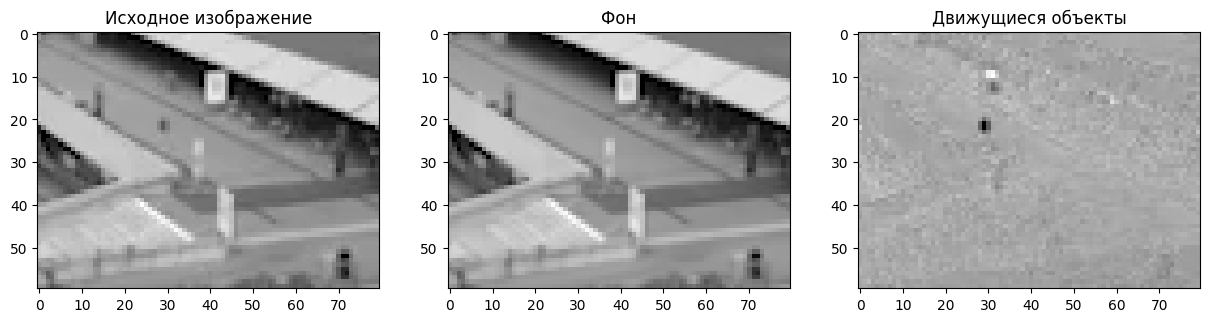

In [ ]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(background, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(moving_objects, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [ ]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 100 x 178, 
number of frames: 3600


In [ ]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = np.reshape(arr3, (nframes, size_w * size_h), order = "C").T

image size: 100 x 178, 
number of frames: 3600


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [ ]:
def rand_svd(M, r, oversampling=10):
    '''
        Input
            M: 2D numpy array
            r: rank value for truncation
            oversampling: number of extra random vectors to approximate range(M)

        Output
            Mr: 2D numpy array of rank r and of the same size as M
            rel_eps: relative error of rank-r approximation Mr
    '''
    m, n = M.shape
    k = r + oversampling
    Omega = np.random.randn(n, k)
    Y = M @ Omega
    Q, _ = np.linalg.qr(Y, mode='reduced')
    B = Q.T @ M
    U_B, S, Vh = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_B
    U = U[:, :r]
    S = S[:r]
    Vh = Vh[:r, :]
    Mr = U @ np.diag(S) @ Vh
    frob_norm_M = np.linalg.norm(M, ord='fro')
    frob_norm_M_minus_Mr = np.linalg.norm(M - Mr, ord='fro')
    rel_eps = frob_norm_M_minus_Mr / frob_norm_M

    return Mr, rel_eps

2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [ ]:
M_rand, _ = rand_svd(M3, r=1)

first_frame = M3[:, 0].reshape(size_w, size_h)
background_rand = M_rand[:, 0].reshape(size_w, size_h)
moving_objects_rand = first_frame - background_rand


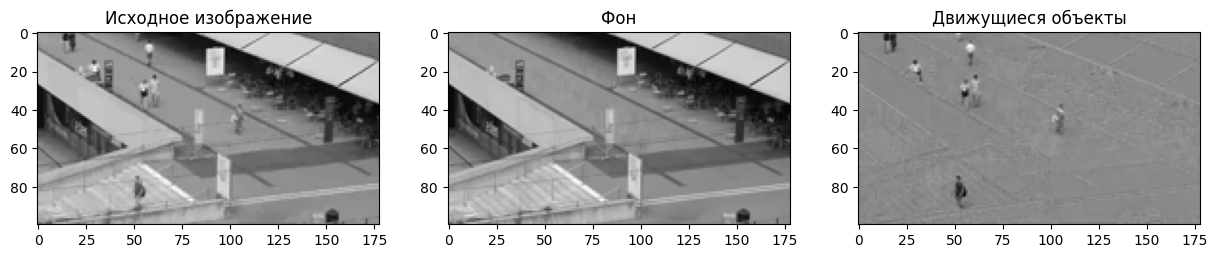

In [ ]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(background_rand, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(moving_objects_rand, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

p_values: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30]
errors: [0.08124440305840305, 0.05290892658972367, 0.051561407230762225, 0.05123227359541092, 0.04910494916684678, 0.048572976660208156, 0.04848496714610297, 0.0477866817852941, 0.047506300102136474, 0.047151523539876825, 0.047067916413149516, 0.04692073216030735, 0.046646591256676175, 0.04683351022792931, 0.04665179344981042, 0.046573892050114765]


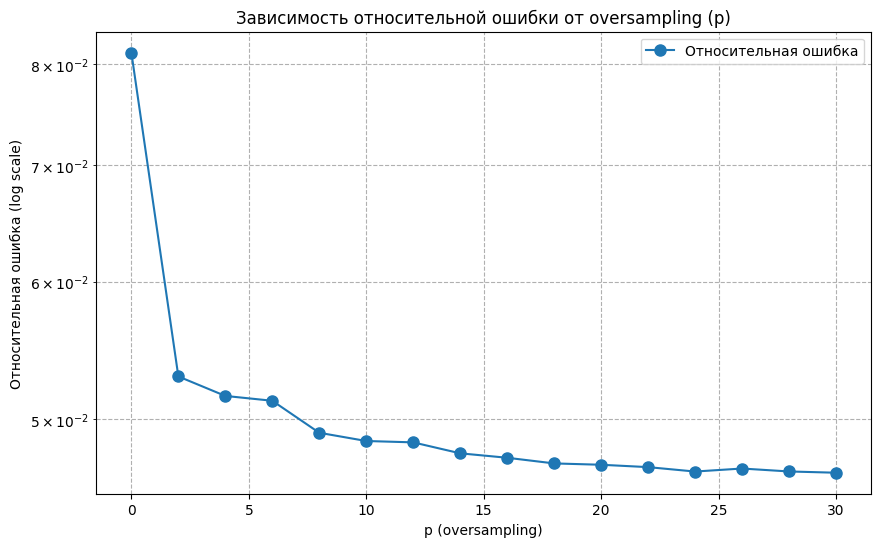

In [ ]:
r = 2
p_values = np.arange(0, 31, 2)
num_trials = 10
errors = []
for p in p_values:
    rel_errors = []
    for _ in range(num_trials):
        M_rand, rel_eps = rand_svd(M3, r=r, oversampling=p)
        rel_errors.append(rel_eps)
    avg_rel_error = np.mean(rel_errors)
    errors.append(avg_rel_error)

print("p_values:", p_values)
print("errors:", errors)

plt.figure(figsize=(10, 6))
plt.semilogy(p_values, errors, 'o-', markersize=8, label='Относительная ошибка')
plt.title('Зависимость относительной ошибки от oversampling (p)')
plt.xlabel('p (oversampling)')
plt.ylabel('Относительная ошибка (log scale)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти.

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [ ]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
arr2 = video_to_array(video2)

image size: 60 x 80, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [ ]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

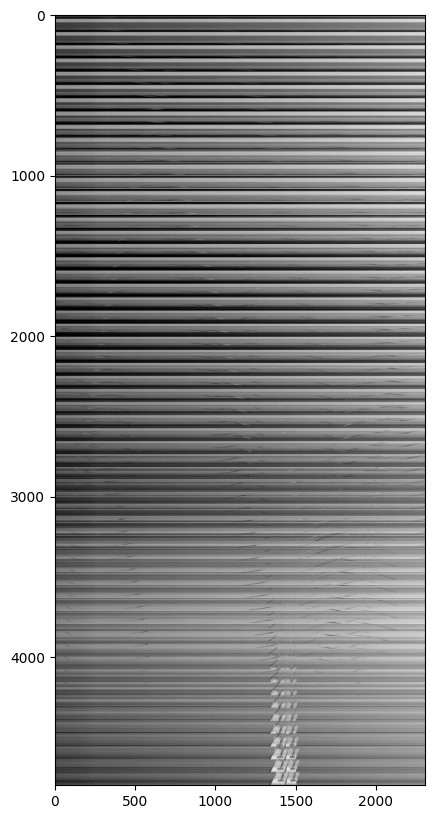

In [ ]:
nframes2, size_w, size_h = arr2.shape
M2 = np.reshape(arr2, (nframes2, size_w * size_h), order="C").T

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [ ]:
import time

In [ ]:
start = time.time()
U, S, Vt = np.linalg.svd(M2, full_matrices=False)
M2_svd = U[:, :2] @ np.diag(S[:2]) @ Vt[:2, :]
svd_time = time.time() - start
start = time.time()
M2_rand, rel_eps_rand = rand_svd(M2, r=2)
rand_time = time.time() - start

In [ ]:
print(f"SVD time: {svd_time:.4f}s, Randomized SVD time: {rand_time:.4f}s")

SVD time: 24.4712s, Randomized SVD time: 0.4228s


3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [ ]:
relative_error_svd = np.linalg.norm(M2 - M2_svd) / np.linalg.norm(M2)

print(f"Относительная ошибка полного SVD: {relative_error_svd:.6f}")
print(f"Относительная ошибка рандомизированного SVD: {rel_eps_rand:.6f}")


Относительная ошибка полного SVD: 0.060632
Относительная ошибка рандомизированного SVD: 0.062978


1) Рандомизированный SVD значительно быстрее, но немного менее точен.

2) Ошибка при изменяющемся освещении выше, чем при постоянном освещении, что указывает на сложность аппроксимации при наличии изменений в яркости, как у нас.



4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [ ]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = np.reshape(M.T, (nframes, size_w, size_h), order="C")
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [ ]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным.

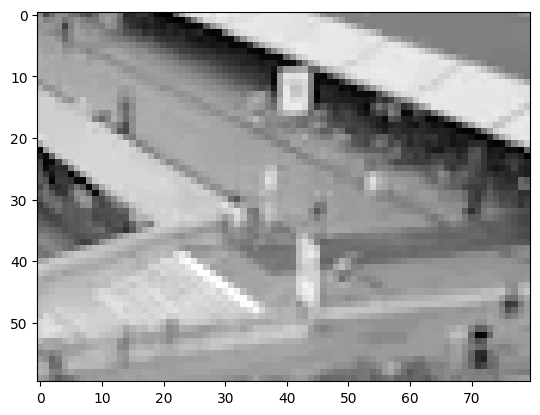

In [ ]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [ ]:
U_2, S_2, VT_2 = np.linalg.svd(M2, full_matrices=False)


In [ ]:
def project_new_frames(U, S, VT, new_frames):
    '''
        Input
            U, S, VT: rank r compact SVD of matrix M2 (U @ S @ VT = M2_r)
            new_frames:  vector (size_h * size_w,) or matrix (size_h * size_w x nframes)

        Output
            proj: projection of new frames to Im(M2_r)
    '''
    if new_frames.ndim == 1:
        new_frames = new_frames.reshape(-1, 1)
    proj = U @ (U.T @ new_frames)

    return proj


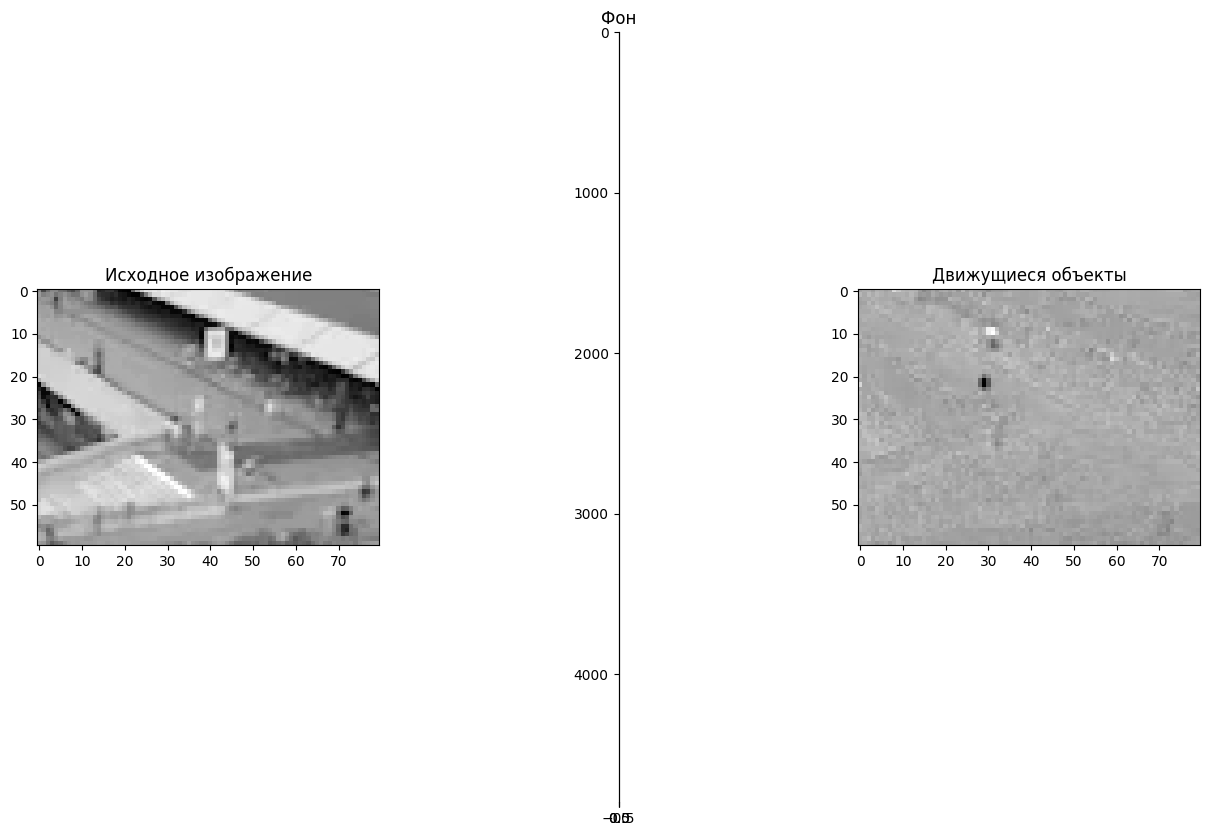

In [ ]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(moving_objects, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [ ]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = np.reshape(remaining, (remaining_nframes, size_w * size_h), order="C").T
M_full = np.concatenate((M2, M_remaining), axis=1)

In [ ]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [ ]:
r = 2
oversampling = 10
m, n = M.shape
k = r + oversampling
Omega = np.random.randn(n, k)
Y = M @ Omega
Q, _ = np.linalg.qr(Y, mode='reduced')
B = Q.T @ M
U_B, S, Vh = np.linalg.svd(B, full_matrices=False)
U = Q @ U_B
U_2_rand = U[:, :r]
S_2_rand = S[:r]
VT_2_rand = Vh[:r, :]


In [ ]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [ ]:
M_true= trunc_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
error_proj = np.linalg.norm(M_true - M_proj, ord='fro') / np.linalg.norm(M_true, ord='fro')
error_proj_rand = np.linalg.norm(M_true - M_proj_rand, ord='fro') / np.linalg.norm(M_true, ord='fro')
print("Относительная ошибка для M_proj:", error_proj)
print("Относительная ошибка для M_proj_rand:", error_proj_rand)

video_true = M_to_video(M_full - M_true, 20, size_w, size_h)
video_proj = M_to_video(M_full - M_proj, 20, size_w, size_h)
video_proj_rand = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)

print("Видео для M_true:")
video_true.ipython_display(width=300, maxduration=250, fps=20)

print("Видео для M_proj:")
video_proj.ipython_display(width=300, maxduration=250, fps=20)

print("Видео для M_proj_rand:")
video_proj_rand.ipython_display(width=300, maxduration=250, fps=20)

Относительная ошибка для M_proj: 0.054214228149261266
Относительная ошибка для M_proj_rand: 0.06919717895806295
Видео для M_true:
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
Видео для M_proj:
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
Видео для M_proj_rand:
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**Выводы:**
M_proj​ ближе к M_true, чем M_proj_ rand. Это ожидаемо, так как M_proj использует обычное SVD, а M_proj_ rand использует rand_svd, который может быть менее точным (и так и было в предыдущих выводах)

Как и ранее, рандомизированный алгоритм может быть менее точен, но он работает быстрее, что делает его полезным для больших данных.



### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros).
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости.
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [ ]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

--2025-02-26 17:21:43--  https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3105 (3.0K) [text/plain]
Saving to: ‘r_pca.py’

r_pca.py            100%[===================>]   3.03K  --.-KB/s    in 0s      

2025-02-26 17:21:43 (26.5 MB/s) - ‘r_pca.py’ saved [3105/3105]



Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

iteration: 1, error: 10.068199117424792
iteration: 100, error: 0.7004423976779164
iteration: 200, error: 0.42632079958320696
iteration: 300, error: 0.28615543342340466
iteration: 400, error: 0.19763762992272108
iteration: 500, error: 0.1491945130599695
iteration: 600, error: 0.1197776098481122
iteration: 700, error: 0.10258379675908802
iteration: 800, error: 0.08740324618615974
iteration: 900, error: 0.07772202053909959
iteration: 1000, error: 0.06319242183847977
iteration: 1100, error: 0.05727756160922441
iteration: 1200, error: 0.04361963207391365
iteration: 1300, error: 0.04277918295975366
iteration: 1400, error: 0.028313363611467284
iteration: 1500, error: 0.028215592055600716
iteration: 1546, error: 0.01770345281066796


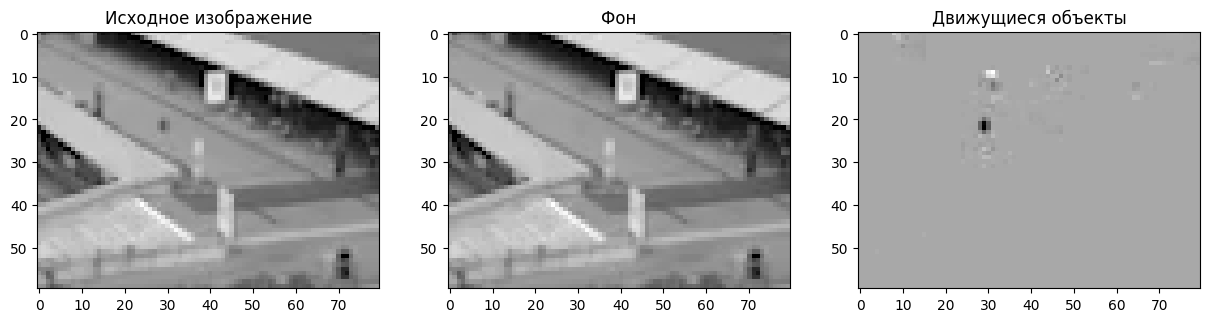

In [ ]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)
first_frame = Mt[:, 0].reshape(size_w, size_h)
background = L[:, 0].reshape(size_w, size_h)
moving_objects = S[:, 0].reshape(size_w, size_h)
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray') # TO BE FILLED
axs[0].set_title("Исходное изображение")
axs[1].imshow(background, cmap='gray') # TO BE FILLED
axs[1].set_title("Фон")
axs[2].imshow(moving_objects, cmap='gray') # TO BE FILLED
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [ ]:
video_rpca = M_to_video(S, 20, size_w, size_h) # TO BE FILLED
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

На шаге 2 алгоритма 4.3 у нас матрица Y=(AA*)^qAΩ. То есть мы применяем A и A * к матрице Ω.

При этом на каждом шаге j алгоритма 4.4  мы применяем операторы A* и A к матрице Q_{j-1}​, то есть умножаем на AA*.

Таким образом, после q итераций в алгоритме 4.4 мы получаем матрицу Q_q, которая эквивалентна общей матрице Q из алгоритма 4.3, так как оба алгоритма выполняют одно и то же преобразование исходной матрицы.

То есть в точной арифметике,оба алгоритма приводят к одному и тому же ортонормированному базису Q, который аппроксимирует пространство столбцов матрицы A.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.

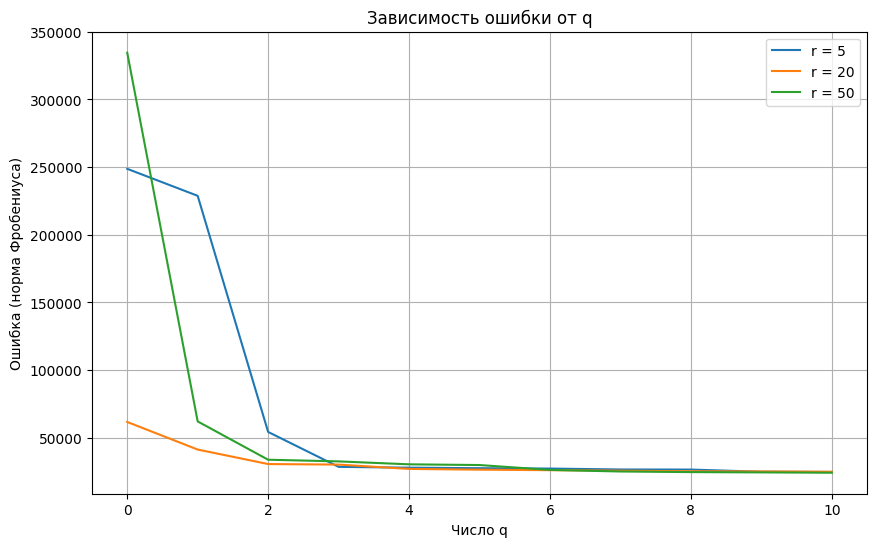

In [ ]:
def adaptive_randomized_svd(A, r, epsilon=1e-6, q_max=10):
    m, n = A.shape
    Q = np.zeros((m, 0))
    errors = []
    for q in range(q_max + 1):
        omega = np.random.randn(n, 1)
        y = A @ omega
        for j in range(Q.shape[1]):
            y -= Q[:, j:j+1] @ (Q[:, j:j+1].T @ y)
        q_new = y / np.linalg.norm(y)
        Q = np.hstack((Q, q_new))
        B = Q.T @ A
        U_tilde, S_tilde, VT_tilde = np.linalg.svd(B, full_matrices=False)
        A_approx = (Q @ U_tilde[:, :r]) @ np.diag(S_tilde[:r]) @ VT_tilde[:r, :]
        error = np.linalg.norm(A - A_approx, 'fro')
        errors.append(error)
        if len(errors) >= r and max(errors[-r:]) <= epsilon / (10 * np.sqrt(2 / np.pi)):
            break
    return errors

ranks = [5, 20, 50]
q_values = range(11)
errors_dict = {}
plt.figure(figsize=(10, 6))
for r in ranks:
    errors = adaptive_randomized_svd(M_full, r)
    errors_dict[r] = errors
    plt.plot(range(len(errors)), errors, label=f'r = {r}')
plt.xlabel('Число q')
plt.ylabel('Ошибка (норма Фробениуса)')
plt.title('Зависимость ошибки от q')
plt.legend()
plt.grid()
plt.show()


Чем больше q, тем меньше ошибка. При малых q видим, что приближение плохое для любого r.

Для r на большом q ошибка минимальная при наибольшем ранге r.